# 3.4 Strategy Evaluation

Comprehensive evaluation of different strategy configurations:
- **K values**: 5, 10, 20 (number of short positions)
- **Confidence gating**: filter to high-confidence predictions
- **Universe filtering**: filter by volume/liquidity
- **Confidence-based allocation**: weight positions by model confidence

Loads saved models (handles both full checkpoints and weights-only saves).

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from itertools import product
from dataclasses import dataclass

import torch
import torch.nn as nn
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## 1. Model Loading Utilities

In [2]:
@dataclass
class ModelConfig:
    """Default config - will be overridden by checkpoint if available."""
    n_fundamental_features: int = 19
    n_price_features: int = 9
    n_embedding_dim: int = 768
    fundamental_latent: int = 32
    price_latent: int = 16
    news_latent: int = 32
    fundamental_dropout: float = 0.5
    price_dropout: float = 0.3
    news_dropout: float = 0.2
    news_alpha: float = 0.8
    batch_size: int = 512
    learning_rate: float = 1e-3
    weight_decay: float = 1e-3
    n_epochs: int = 25


class MultiBranchRanker(nn.Module):
    """Multi-branch ranking model."""
    
    def __init__(self, config):
        super().__init__()
        self.config = config
        
        self.fund_encoder = nn.Sequential(
            nn.Linear(config.n_fundamental_features, 64),
            nn.ReLU(),
            nn.Dropout(config.fundamental_dropout),
            nn.Linear(64, config.fundamental_latent),
            nn.ReLU(),
        )
        
        self.price_encoder = nn.Sequential(
            nn.Linear(config.n_price_features, 32),
            nn.ReLU(),
            nn.Dropout(config.price_dropout),
            nn.Linear(32, config.price_latent),
            nn.ReLU(),
        )
        
        self.news_encoder = nn.Sequential(
            nn.Linear(config.n_embedding_dim, 128),
            nn.ReLU(),
            nn.Dropout(config.news_dropout),
            nn.Linear(128, config.news_latent),
            nn.ReLU(),
        )
        
        fused_dim = config.fundamental_latent + config.price_latent + config.news_latent
        self.output_head = nn.Sequential(
            nn.Linear(fused_dim, 32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, 1),
        )
    
    def forward(self, price, fund, emb):
        h_f = self.fund_encoder(fund)
        h_p = self.price_encoder(price)
        h_n = self.news_encoder(emb)
        h_n_scaled = self.config.news_alpha * h_n
        h = torch.cat([h_f, h_p, h_n_scaled], dim=-1)
        return self.output_head(h).squeeze(-1)

In [3]:
def load_model(path, device, default_config=None):
    """
    Load model from checkpoint, handling different save formats:
    - Full save: dict with 'model_state_dict' and 'config'
    - Weights only: just the state_dict
    
    Returns: (model, config, metadata)
    """
    path = Path(path)
    if not path.exists():
        raise FileNotFoundError(f"Model not found: {path}")
    
    checkpoint = torch.load(path, map_location=device, weights_only=False)
    
    # Determine save format
    if isinstance(checkpoint, dict) and "model_state_dict" in checkpoint:
        # Full save format
        state_dict = checkpoint["model_state_dict"]
        config = checkpoint.get("config", default_config or ModelConfig())
        metadata = {
            "price_cols": checkpoint.get("price_cols"),
            "fund_cols": checkpoint.get("fund_cols"),
            "emb_cols": checkpoint.get("emb_cols"),
            "training_approach": checkpoint.get("training_approach"),
            "results": checkpoint.get("results"),
        }
        print(f"Loaded full checkpoint from {path}")
        if hasattr(config, 'fundamental_dropout'):
            print(f"  Config: fund_drop={config.fundamental_dropout}, price_drop={config.price_dropout}, news_drop={config.news_dropout}")
    elif isinstance(checkpoint, dict) and any(k.startswith("fund_encoder") for k in checkpoint.keys()):
        # Weights-only format (state_dict directly)
        state_dict = checkpoint
        config = default_config or ModelConfig()
        metadata = {}
        print(f"Loaded weights-only checkpoint from {path}")
    else:
        raise ValueError(f"Unknown checkpoint format in {path}")
    
    # Create and load model
    model = MultiBranchRanker(config).to(device)
    model.load_state_dict(state_dict)
    model.eval()
    
    return model, config, metadata


def list_available_models(data_dir="data"):
    """List all .pt model files in the data directory."""
    data_dir = Path(data_dir)
    models = sorted(data_dir.glob("model*.pt"))
    print(f"Found {len(models)} model files:")
    for m in models:
        size_mb = m.stat().st_size / 1024 / 1024
        print(f"  {m.name} ({size_mb:.1f} MB)")
    return models

## 2. Load Data

In [4]:
df = pd.read_parquet("data/ml_dataset.pqt")
df["feature_date"] = pd.to_datetime(df["feature_date"])

print(f"Dataset: {len(df):,} rows")
print(f"Date range: {df['feature_date'].min().date()} to {df['feature_date'].max().date()}")
print(f"Symbols: {df['symbol'].nunique():,}")

Dataset: 2,092,929 rows
Date range: 2021-01-13 to 2025-12-18
Symbols: 3,506


In [5]:
# Feature columns
price_feat_cols = [
    "overnight_gap_z", "intraday_ret_z",
    "ret_1d_z", "ret_2d_z", "ret_3d_z", "ret_5d_z",
    "vol_5d_z", "dist_from_high_5d_z", "dist_from_low_5d_z"
]
fund_feat_cols = [c for c in df.columns if c.endswith("_z") and c not in price_feat_cols and c != "news_count_z"]
emb_cols = [c for c in df.columns if c.startswith("emb_")]

print(f"Price features: {len(price_feat_cols)}")
print(f"Fundamental features: {len(fund_feat_cols)}")
print(f"Embedding dims: {len(emb_cols)}")

Price features: 9
Fundamental features: 19
Embedding dims: 768


In [6]:
# Time-based split - use test set for strategy evaluation
dates = sorted(df["feature_date"].unique())
n_dates = len(dates)
val_end_idx = int(n_dates * 0.8)

test_dates = set(dates[val_end_idx:])
test_df = df[df["feature_date"].isin(test_dates)].copy()

# Filter to news-only for realistic evaluation
has_news = (test_df[emb_cols].abs().sum(axis=1) > 0)
test_df_news = test_df[has_news].copy()

print(f"Test set: {len(test_df):,} rows, {len(test_dates)} days")
print(f"Test set (news-only): {len(test_df_news):,} rows ({len(test_df_news)/len(test_df)*100:.1f}%)")

Test set: 464,188 rows, 238 days
Test set (news-only): 128,502 rows (27.7%)


## 3. Load Model

In [32]:
# List available models
available_models = list_available_models("data")

Found 17 model files:
  model_best.pt (0.4 MB)
  model_best_26M_pairs_.pt (0.4 MB)
  model_best_all_pairs-best.pt (0.4 MB)
  model_best_all_pairs.pt (0.4 MB)
  model_best_all_pairs_.pt (0.4 MB)
  model_best_all_pairs_2.pt (0.4 MB)
  model_best_all_pairs_ep3.pt (0.4 MB)
  model_best_all_pairs_ep6.pt (0.4 MB)
  model_capped.pt (0.4 MB)
  model_dropout_optimized.pt (0.4 MB)
  model_final.pt (0.4 MB)
  model_final_full.pt (0.4 MB)
  model_single_pair.pt (0.4 MB)
  model_single_pair_fixed.pt (0.4 MB)
  model_single_pair_sharpe10.pt (0.4 MB)
  model_single_pair_sharpe8.pt (0.4 MB)
  model_single_pair_sharpe9.pt (0.4 MB)


In [8]:
available_models

[PosixPath('data/model_best.pt'),
 PosixPath('data/model_best_26M_pairs_.pt'),
 PosixPath('data/model_best_all_pairs-best.pt'),
 PosixPath('data/model_best_all_pairs.pt'),
 PosixPath('data/model_best_all_pairs_.pt'),
 PosixPath('data/model_best_all_pairs_2.pt'),
 PosixPath('data/model_best_all_pairs_ep3.pt'),
 PosixPath('data/model_best_all_pairs_ep6.pt'),
 PosixPath('data/model_capped.pt'),
 PosixPath('data/model_dropout_optimized.pt'),
 PosixPath('data/model_final.pt'),
 PosixPath('data/model_final_full.pt'),
 PosixPath('data/model_single_pair.pt'),
 PosixPath('data/model_single_pair_fixed.pt'),
 PosixPath('data/model_single_pair_sharpe9.pt')]

In [40]:
# Select model to evaluate
#MODEL_PATH = "data/model_single_pair_sharpe10.pt"  # Change this to evaluate different models
MODEL_PATH = "data/model_hyperparam_optimized.pt"
# Create default config matching feature dimensions
default_config = ModelConfig(
    n_fundamental_features=len(fund_feat_cols),
    n_price_features=len(price_feat_cols),
    n_embedding_dim=len(emb_cols),
)

model, config, metadata = load_model(MODEL_PATH, device, default_config)

Loaded full checkpoint from data/model_hyperparam_optimized.pt
  Config: fund_drop=0.8, price_drop=0.4, news_drop=0.2


## 4. Score All Stocks

In [41]:
@torch.no_grad()
def score_dataframe(model, df, price_cols, fund_cols, emb_cols, device, batch_size=1024):
    """Score all rows and return DataFrame with scores and confidence."""
    model.eval()
    
    price_arr = torch.tensor(df[price_cols].values.astype(np.float32))
    fund_arr = torch.tensor(df[fund_cols].values.astype(np.float32))
    emb_arr = torch.tensor(df[emb_cols].values.astype(np.float32))
    
    scores = []
    for i in range(0, len(df), batch_size):
        price = price_arr[i:i+batch_size].to(device)
        fund = fund_arr[i:i+batch_size].to(device)
        emb = emb_arr[i:i+batch_size].to(device)
        score = model(price, fund, emb)
        scores.append(score.cpu().numpy())
    
    df_scored = df.copy()
    df_scored["score"] = np.concatenate(scores)
    
    # Compute per-day z-score for confidence measure
    df_scored["score_zscore"] = df_scored.groupby("feature_date")["score"].transform(
        lambda x: (x - x.mean()) / x.std() if x.std() > 0 else 0
    )
    
    # Confidence = absolute z-score (how extreme the prediction is)
    df_scored["confidence"] = df_scored["score_zscore"].abs()
    
    return df_scored

In [42]:
# Score test set
test_scored = score_dataframe(model, test_df_news, price_feat_cols, fund_feat_cols, emb_cols, device)

print(f"Scored {len(test_scored):,} rows")
print(f"Score range: [{test_scored['score'].min():.3f}, {test_scored['score'].max():.3f}]")
print(f"Confidence range: [{test_scored['confidence'].min():.3f}, {test_scored['confidence'].max():.3f}]")

Scored 128,502 rows
Score range: [-0.683, -0.063]
Confidence range: [0.000, 10.933]


## 5. Strategy Functions

In [43]:
def apply_universe_filter(df, volume_percentile=20):
    """
    Filter to more liquid stocks based on volume.
    Keeps stocks above the given percentile of daily volume.
    """
    if "volume" not in df.columns and "vol_5d_z" in df.columns:
        # Use volume z-score as proxy - higher z-score = higher volume
        threshold = df["vol_5d_z"].quantile(volume_percentile / 100)
        return df[df["vol_5d_z"] >= threshold].copy()
    elif "volume" in df.columns:
        threshold = df["volume"].quantile(volume_percentile / 100)
        return df[df["volume"] >= threshold].copy()
    else:
        # No volume data available, return as-is
        return df.copy()


def apply_confidence_gate(df, min_confidence=1.0):
    """
    Filter to high-confidence predictions.
    min_confidence is in z-score units (e.g., 1.0 = 1 std from mean).
    """
    return df[df["confidence"] >= min_confidence].copy()


def compute_position_weights(df, k, use_confidence_weighting=False):
    """
    Compute position weights for bottom-K stocks.
    
    If use_confidence_weighting=True, weight by confidence.
    Otherwise, equal weight.
    """
    bottom_k = df.nsmallest(k, "score")
    
    if use_confidence_weighting and len(bottom_k) > 0:
        # Weight by confidence, normalized to sum to 1
        weights = bottom_k["confidence"].values
        weights = weights / weights.sum() if weights.sum() > 0 else np.ones(len(weights)) / len(weights)
    else:
        # Equal weight
        weights = np.ones(len(bottom_k)) / len(bottom_k) if len(bottom_k) > 0 else np.array([])
    
    return bottom_k, weights


def compute_daily_short_return(
    df_day,
    k=5,
    clip_return=0.10,
    use_universe_filter=False,
    use_confidence_gate=False,
    use_confidence_weighting=False,
    min_confidence=1.0,
    volume_percentile=20,
):
    """
    Compute short return for a single day with various strategy options.
    
    Returns: (return, n_positions, avg_confidence)
    """
    df_filtered = df_day.copy()
    
    # Apply universe filter
    if use_universe_filter:
        df_filtered = apply_universe_filter(df_filtered, volume_percentile)
    
    # Apply confidence gate
    if use_confidence_gate:
        df_filtered = apply_confidence_gate(df_filtered, min_confidence)
    
    # Need enough stocks
    if len(df_filtered) < k:
        return np.nan, 0, 0
    
    # Get positions and weights
    bottom_k, weights = compute_position_weights(df_filtered, k, use_confidence_weighting)
    
    if len(bottom_k) == 0:
        return np.nan, 0, 0
    
    # Compute return (short = negative of actual return)
    clipped_returns = bottom_k["target_return"].clip(-clip_return, clip_return).values
    short_return = -np.sum(clipped_returns * weights)
    
    avg_confidence = bottom_k["confidence"].mean()
    
    return short_return, len(bottom_k), avg_confidence


def run_strategy(
    df_scored,
    k=5,
    clip_return=0.10,
    use_universe_filter=False,
    use_confidence_gate=False,
    use_confidence_weighting=False,
    min_confidence=1.0,
    volume_percentile=20,
):
    """
    Run strategy across all dates and return results.
    """
    results = []
    
    for date, df_day in df_scored.groupby("feature_date"):
        ret, n_pos, avg_conf = compute_daily_short_return(
            df_day,
            k=k,
            clip_return=clip_return,
            use_universe_filter=use_universe_filter,
            use_confidence_gate=use_confidence_gate,
            use_confidence_weighting=use_confidence_weighting,
            min_confidence=min_confidence,
            volume_percentile=volume_percentile,
        )
        
        if not np.isnan(ret):
            results.append({
                "date": date,
                "return": ret,
                "n_positions": n_pos,
                "avg_confidence": avg_conf,
            })
    
    return pd.DataFrame(results)


def compute_strategy_metrics(results_df):
    """Compute performance metrics from strategy results."""
    if len(results_df) < 2:
        return {
            "sharpe": 0, "total_return": 0, "mean_return": 0,
            "win_rate": 0, "avg_positions": 0, "n_days": 0,
        }
    
    returns = results_df["return"]
    mean_ret = returns.mean()
    std_ret = returns.std()
    
    sharpe = mean_ret / std_ret * np.sqrt(252) if std_ret > 0 else 0
    total_return = (1 + returns).cumprod().iloc[-1] - 1
    win_rate = (returns > 0).mean()
    avg_positions = results_df["n_positions"].mean()
    
    return {
        "sharpe": sharpe,
        "total_return": total_return,
        "mean_return": mean_ret,
        "win_rate": win_rate,
        "avg_positions": avg_positions,
        "n_days": len(results_df),
    }

## 6. Strategy Grid Search

In [44]:
# Strategy configuration space
K_VALUES = [5, 10, 20]
CONFIDENCE_GATE = [False, True]
UNIVERSE_FILTER = [False, True]
CONFIDENCE_WEIGHTING = [False, True]

# Fixed parameters
MIN_CONFIDENCE = 1.0  # 1 std for confidence gating
VOLUME_PERCENTILE = 20  # Top 80% by volume
CLIP_RETURN = 0.10

all_configs = list(product(K_VALUES, CONFIDENCE_GATE, UNIVERSE_FILTER, CONFIDENCE_WEIGHTING))
print(f"Total strategy configurations: {len(all_configs)}")

Total strategy configurations: 24


In [45]:
# Run all strategy configurations
strategy_results = []

print("Running strategy evaluation...")
print("=" * 100)

for i, (k, conf_gate, univ_filter, conf_weight) in enumerate(all_configs):
    results_df = run_strategy(
        test_scored,
        k=k,
        clip_return=CLIP_RETURN,
        use_universe_filter=univ_filter,
        use_confidence_gate=conf_gate,
        use_confidence_weighting=conf_weight,
        min_confidence=MIN_CONFIDENCE,
        volume_percentile=VOLUME_PERCENTILE,
    )
    
    metrics = compute_strategy_metrics(results_df)
    
    result = {
        "k": k,
        "confidence_gate": conf_gate,
        "universe_filter": univ_filter,
        "confidence_weighting": conf_weight,
        **metrics,
    }
    strategy_results.append(result)
    
    gate_str = "gate" if conf_gate else "    "
    univ_str = "univ" if univ_filter else "    "
    weight_str = "wgt" if conf_weight else "   "
    
    print(f"[{i+1:2d}/{len(all_configs)}] K={k:2d} {gate_str} {univ_str} {weight_str} | "
          f"Sharpe={metrics['sharpe']:5.2f}  Return={metrics['total_return']*100:6.1f}%  "
          f"WinRate={metrics['win_rate']*100:4.1f}%  Days={metrics['n_days']}")

print("=" * 100)

Running strategy evaluation...
[ 1/24] K= 5               | Sharpe= 5.39  Return=1685.0%  WinRate=63.0%  Days=238
[ 2/24] K= 5           wgt | Sharpe= 5.93  Return=2550.2%  WinRate=62.2%  Days=238
[ 3/24] K= 5      univ     | Sharpe= 5.36  Return=1665.8%  WinRate=63.0%  Days=238
[ 4/24] K= 5      univ wgt | Sharpe= 5.90  Return=2517.9%  WinRate=62.2%  Days=238
[ 5/24] K= 5 gate          | Sharpe= 5.39  Return=1685.0%  WinRate=63.0%  Days=238
[ 6/24] K= 5 gate      wgt | Sharpe= 5.93  Return=2550.2%  WinRate=62.2%  Days=238
[ 7/24] K= 5 gate univ     | Sharpe= 5.36  Return=1665.8%  WinRate=63.0%  Days=238
[ 8/24] K= 5 gate univ wgt | Sharpe= 5.90  Return=2517.9%  WinRate=62.2%  Days=238
[ 9/24] K=10               | Sharpe= 4.44  Return= 553.5%  WinRate=60.1%  Days=238
[10/24] K=10           wgt | Sharpe= 5.30  Return= 963.7%  WinRate=60.5%  Days=238
[11/24] K=10      univ     | Sharpe= 4.41  Return= 542.7%  WinRate=59.7%  Days=238
[12/24] K=10      univ wgt | Sharpe= 5.27  Return= 947.5

## 7. Analyze Results

In [46]:
# Create results DataFrame
results_df = pd.DataFrame(strategy_results)
results_df = results_df.sort_values("sharpe", ascending=False)

print("\nAll Configurations (sorted by Sharpe):")
print("=" * 100)
display_cols = ["k", "confidence_gate", "universe_filter", "confidence_weighting", 
                "sharpe", "total_return", "win_rate", "n_days"]
print(results_df[display_cols].to_string(index=False))


All Configurations (sorted by Sharpe):
 k  confidence_gate  universe_filter  confidence_weighting   sharpe  total_return  win_rate  n_days
 5             True            False                  True 5.925514     25.501680  0.621849     238
 5            False            False                  True 5.925514     25.501680  0.621849     238
 5            False             True                  True 5.895009     25.179404  0.621849     238
 5             True             True                  True 5.895009     25.179404  0.621849     238
 5            False            False                 False 5.389691     16.849540  0.630252     238
 5             True            False                 False 5.389691     16.849540  0.630252     238
 5            False             True                 False 5.362900     16.657596  0.630252     238
 5             True             True                 False 5.362900     16.657596  0.630252     238
10            False            False                  True 5

In [47]:
# Analyze by individual parameter
print("\n" + "=" * 60)
print("ANALYSIS BY PARAMETER")
print("=" * 60)

print("\nBy K value:")
print(results_df.groupby("k")[["sharpe", "total_return", "win_rate"]].mean().round(3))

print("\nBy Confidence Gating:")
print(results_df.groupby("confidence_gate")[["sharpe", "total_return", "win_rate"]].mean().round(3))

print("\nBy Universe Filtering:")
print(results_df.groupby("universe_filter")[["sharpe", "total_return", "win_rate"]].mean().round(3))

print("\nBy Confidence Weighting:")
print(results_df.groupby("confidence_weighting")[["sharpe", "total_return", "win_rate"]].mean().round(3))


ANALYSIS BY PARAMETER

By K value:
    sharpe  total_return  win_rate
k                                 
5    5.643        21.047     0.626
10   4.853         7.519     0.602
20   4.038         3.572     0.563

By Confidence Gating:
                 sharpe  total_return  win_rate
confidence_gate                                
False             4.845        10.712     0.597
True              4.845        10.712     0.597

By Universe Filtering:
                 sharpe  total_return  win_rate
universe_filter                                
False             4.857        10.781     0.597
True              4.832        10.644     0.597

By Confidence Weighting:
                      sharpe  total_return  win_rate
confidence_weighting                                
False                   4.44         8.243     0.597
True                    5.25        13.181     0.597


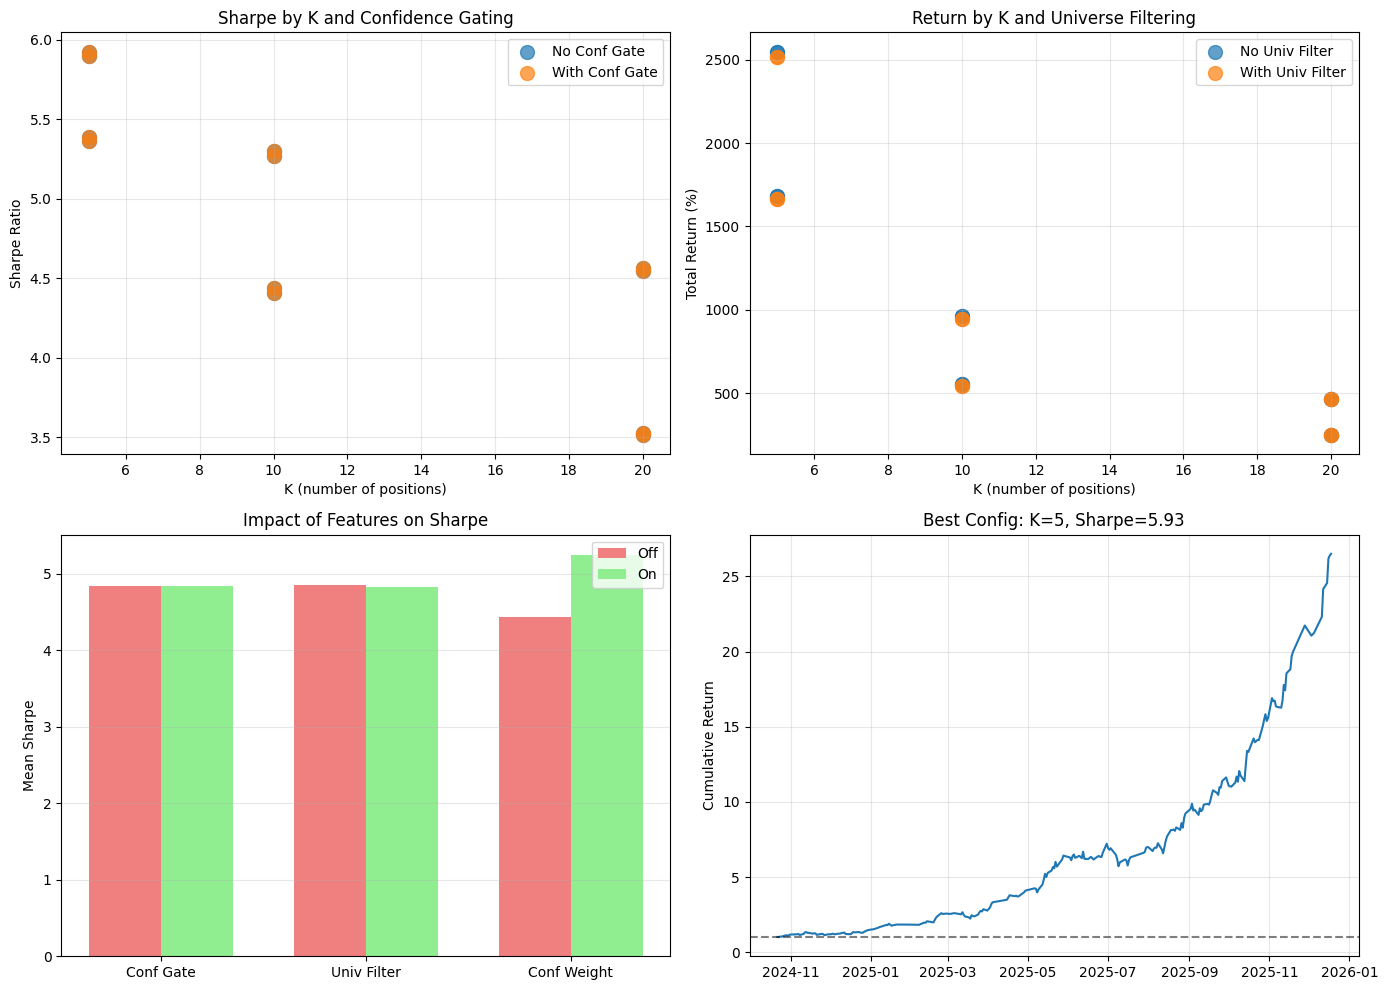

In [48]:
# Visualize results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Sharpe by K
ax = axes[0, 0]
for conf_gate in [False, True]:
    subset = results_df[results_df["confidence_gate"] == conf_gate]
    label = "With Conf Gate" if conf_gate else "No Conf Gate"
    ax.scatter(subset["k"], subset["sharpe"], label=label, alpha=0.7, s=100)
ax.set_xlabel("K (number of positions)")
ax.set_ylabel("Sharpe Ratio")
ax.set_title("Sharpe by K and Confidence Gating")
ax.legend()
ax.grid(True, alpha=0.3)

# Return by K
ax = axes[0, 1]
for univ_filter in [False, True]:
    subset = results_df[results_df["universe_filter"] == univ_filter]
    label = "With Univ Filter" if univ_filter else "No Univ Filter"
    ax.scatter(subset["k"], subset["total_return"] * 100, label=label, alpha=0.7, s=100)
ax.set_xlabel("K (number of positions)")
ax.set_ylabel("Total Return (%)")
ax.set_title("Return by K and Universe Filtering")
ax.legend()
ax.grid(True, alpha=0.3)

# Sharpe distribution by feature
ax = axes[1, 0]
features = ["confidence_gate", "universe_filter", "confidence_weighting"]
x_pos = np.arange(len(features))
width = 0.35

means_false = [results_df[results_df[f] == False]["sharpe"].mean() for f in features]
means_true = [results_df[results_df[f] == True]["sharpe"].mean() for f in features]

ax.bar(x_pos - width/2, means_false, width, label="Off", color="lightcoral")
ax.bar(x_pos + width/2, means_true, width, label="On", color="lightgreen")
ax.set_xticks(x_pos)
ax.set_xticklabels(["Conf Gate", "Univ Filter", "Conf Weight"])
ax.set_ylabel("Mean Sharpe")
ax.set_title("Impact of Features on Sharpe")
ax.legend()
ax.grid(True, alpha=0.3, axis="y")

# Best config equity curve
ax = axes[1, 1]
best_config = results_df.iloc[0]
best_results = run_strategy(
    test_scored,
    k=int(best_config["k"]),
    clip_return=CLIP_RETURN,
    use_universe_filter=best_config["universe_filter"],
    use_confidence_gate=best_config["confidence_gate"],
    use_confidence_weighting=best_config["confidence_weighting"],
    min_confidence=MIN_CONFIDENCE,
    volume_percentile=VOLUME_PERCENTILE,
)
cumret = (1 + best_results["return"]).cumprod()
ax.plot(best_results["date"], cumret)
ax.axhline(1, color="black", linestyle="--", alpha=0.5)
ax.set_ylabel("Cumulative Return")
ax.set_title(f"Best Config: K={int(best_config['k'])}, Sharpe={best_config['sharpe']:.2f}")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Best Configuration Details

In [49]:
# Show top 5 configurations
print("\n" + "=" * 60)
print("TOP 5 CONFIGURATIONS")
print("=" * 60)

for i, row in results_df.head(5).iterrows():
    print(f"\n#{results_df.index.get_loc(i) + 1}:")
    print(f"  K = {int(row['k'])}")
    print(f"  Confidence Gating: {row['confidence_gate']}")
    print(f"  Universe Filter: {row['universe_filter']}")
    print(f"  Confidence Weighting: {row['confidence_weighting']}")
    print(f"  ---")
    print(f"  Sharpe Ratio: {row['sharpe']:.2f}")
    print(f"  Total Return: {row['total_return']*100:.1f}%")
    print(f"  Win Rate: {row['win_rate']*100:.1f}%")
    print(f"  Trading Days: {int(row['n_days'])}")


TOP 5 CONFIGURATIONS

#1:
  K = 5
  Confidence Gating: True
  Universe Filter: False
  Confidence Weighting: True
  ---
  Sharpe Ratio: 5.93
  Total Return: 2550.2%
  Win Rate: 62.2%
  Trading Days: 238

#2:
  K = 5
  Confidence Gating: False
  Universe Filter: False
  Confidence Weighting: True
  ---
  Sharpe Ratio: 5.93
  Total Return: 2550.2%
  Win Rate: 62.2%
  Trading Days: 238

#3:
  K = 5
  Confidence Gating: False
  Universe Filter: True
  Confidence Weighting: True
  ---
  Sharpe Ratio: 5.90
  Total Return: 2517.9%
  Win Rate: 62.2%
  Trading Days: 238

#4:
  K = 5
  Confidence Gating: True
  Universe Filter: True
  Confidence Weighting: True
  ---
  Sharpe Ratio: 5.90
  Total Return: 2517.9%
  Win Rate: 62.2%
  Trading Days: 238

#5:
  K = 5
  Confidence Gating: False
  Universe Filter: False
  Confidence Weighting: False
  ---
  Sharpe Ratio: 5.39
  Total Return: 1685.0%
  Win Rate: 63.0%
  Trading Days: 238


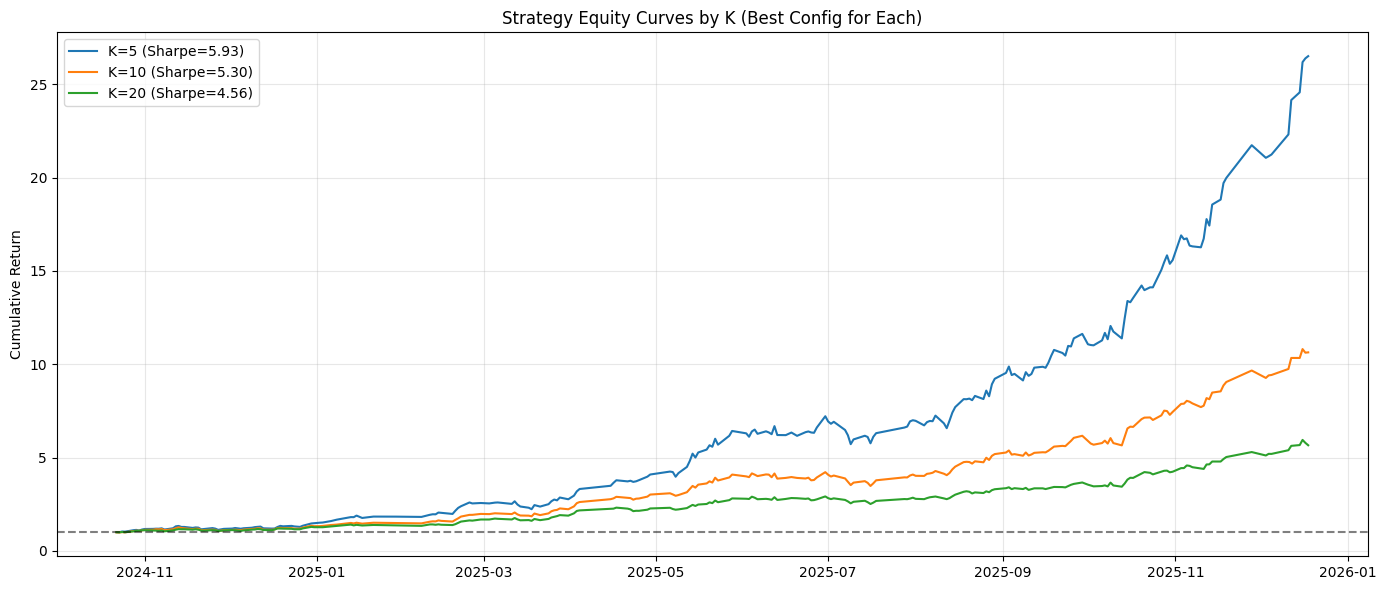

In [50]:
# Compare equity curves for different K values (best config for each K)
fig, ax = plt.subplots(figsize=(14, 6))

for k in K_VALUES:
    # Get best config for this K
    k_results = results_df[results_df["k"] == k].iloc[0]
    
    curve_results = run_strategy(
        test_scored,
        k=k,
        clip_return=CLIP_RETURN,
        use_universe_filter=k_results["universe_filter"],
        use_confidence_gate=k_results["confidence_gate"],
        use_confidence_weighting=k_results["confidence_weighting"],
        min_confidence=MIN_CONFIDENCE,
        volume_percentile=VOLUME_PERCENTILE,
    )
    
    cumret = (1 + curve_results["return"]).cumprod()
    ax.plot(curve_results["date"], cumret, label=f"K={k} (Sharpe={k_results['sharpe']:.2f})")

ax.axhline(1, color="black", linestyle="--", alpha=0.5)
ax.set_ylabel("Cumulative Return")
ax.set_title("Strategy Equity Curves by K (Best Config for Each)")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 9. Save Results

In [51]:
# Save strategy evaluation results
results_df.to_parquet("data/strategy_evaluation_results.pqt")
print("Saved results to data/strategy_evaluation_results.pqt")

# Save best configuration
best = results_df.iloc[0]
best_config_dict = {
    "k": int(best["k"]),
    "confidence_gate": bool(best["confidence_gate"]),
    "universe_filter": bool(best["universe_filter"]),
    "confidence_weighting": bool(best["confidence_weighting"]),
    "min_confidence": MIN_CONFIDENCE,
    "volume_percentile": VOLUME_PERCENTILE,
    "clip_return": CLIP_RETURN,
    "metrics": {
        "sharpe": float(best["sharpe"]),
        "total_return": float(best["total_return"]),
        "win_rate": float(best["win_rate"]),
    },
    "model_path": str(MODEL_PATH),
}

import json
with open("data/best_strategy_config.json", "w") as f:
    json.dump(best_config_dict, f, indent=2)
print("Saved best config to data/best_strategy_config.json")

Saved results to data/strategy_evaluation_results.pqt
Saved best config to data/best_strategy_config.json
